종속변수가 있으면 지도학습, 종속변수 없으면 비지도학습

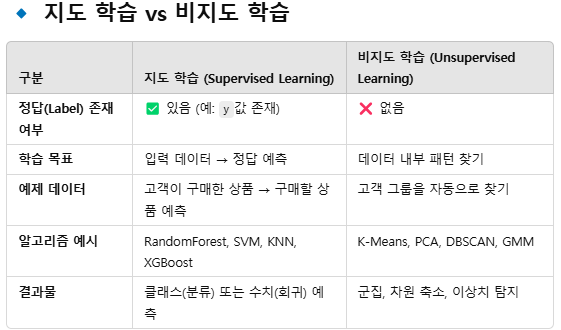

# 비지도학습 종류
레이블(정답)이 없는 데이터에서 패턴을 찾는 머신러닝 방법  
군집화(Clustering), 차원 축소(Dimensionality Reduction), 이상치 탐지(Anomaly Detection)
- K-Means
- DBSCAN

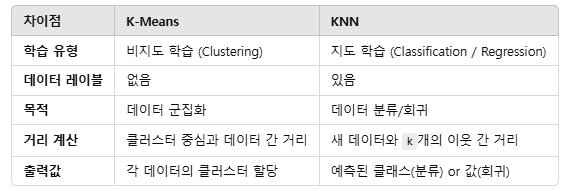

In [74]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime


In [89]:
retail_df=pd.read_csv('/content/online_retail.csv')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


InvoiceNo: 각 송장을 식별하는 고유 ID  
StockCode: 재고가 있는 각 품목의 고유 ID  
Description: 각 항목에 대한 간단한 설명  
Quantity: 구입한 품목의 수  
UnitPrice: 각 항목의 가격  
CustomerID: 고객별 고유 ID  
Country: 고객이 살고 있는 국가

In [90]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240007 entries, 0 to 240006
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    240007 non-null  object 
 1   StockCode    240007 non-null  object 
 2   Description  239106 non-null  object 
 3   Quantity     240007 non-null  int64  
 4   InvoiceDate  240007 non-null  object 
 5   UnitPrice    240007 non-null  float64
 6   CustomerID   172782 non-null  float64
 7   Country      240007 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 14.6+ MB


In [91]:
print(retail_df.isnull().sum())

InvoiceNo          0
StockCode          0
Description      901
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     67225
Country            0
dtype: int64


In [92]:
retail_df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,240007,240007,239106,240007.000000,240007,240007.000000,172782.000000,240007
unique,12468,3645,3617,NaN,11240,NaN,NaN,38
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,12/6/10 16:57,NaN,NaN,United Kingdom
freq,675,1294,1319,NaN,675,NaN,NaN,220279
mean,NaN,NaN,NaN,9.277646,NaN,5.124265,15274.819941,NaN
std,NaN,NaN,NaN,223.061608,NaN,119.992279,1725.093177,NaN
min,NaN,NaN,NaN,-74215.000000,NaN,0.000000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13842.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.100000,15132.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.210000,16814.000000,NaN


In [93]:
#오류데이터 정제
retail_df=retail_df[retail_df['Quantity']>0]
retail_df=retail_df[retail_df['UnitPrice']>0]
retail_df=retail_df[retail_df['CustomerID'].notnull()]

#CusomerID 자료형을 정수형으로 변환
retail_df['CustomerID']=retail_df['CustomerID'].astype(int)
print(retail_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 168662 entries, 0 to 240006
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    168662 non-null  object 
 1   StockCode    168662 non-null  object 
 2   Description  168662 non-null  object 
 3   Quantity     168662 non-null  int64  
 4   InvoiceDate  168662 non-null  object 
 5   UnitPrice    168662 non-null  float64
 6   CustomerID   168662 non-null  int64  
 7   Country      168662 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 11.6+ MB
None


In [94]:
#중복 레코드 제거
retail_df.drop_duplicates(inplace=True)
print(retail_df.shape)

(166733, 8)


In [95]:
#개별 제품을 알 수 있는 StockCode의 개수 value_counts()로 제품수, invoiceNo의 개수로 거래 건수,
#CustomerID의 개수로 고객수를 구함
pd.DataFrame([
  {'Product':len(retail_df['StockCode'].value_counts()),
  'Transaction': len(retail_df['InvoiceNo'].value_counts()),
  'Customer': len(retail_df['CustomerID'].value_counts())}],
  columns=['Product', 'Transaction', 'Customer'],
  index=['counts'])

,Product,Transaction,Customer
counts,3264,8589,2931


In [96]:
#고객의 주문횟수, 주문총액, 그리고 마지막 주문후 며칠지났는지 정보 추출
retail_df['SaleAmount']=retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850,United Kingdom,20.34


In [97]:
#고객의 마지막 주문 후 경과일(Elapsed Days), 주문횟수(Freq), 주문총액(Total Amount)구하기
aggregations={
    'InvoiceNo':'count',
    'SaleAmount':'sum',
    'InvoiceDate':'max'
}
customer_df=retail_df.groupby('CustomerID').agg(aggregations)
customer_df=customer_df.reset_index()
customer_df.head()

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.60,1/18/11 10:01
1,12347,102,2205.95,6/9/11 13:01
2,12348,28,1487.24,4/5/11 10:47
3,12350,17,334.40,2/2/11 16:01
4,12352,38,1561.81,3/22/11 16:08


In [98]:
# 컬럼이름 바꾸기
customer_df = customer_df.rename(columns={'InvoiceNo': 'Freq', 'InvoiceDate': 'ElapsedDays'})

In [103]:
customer_df

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,1/18/11 10:01
1,12347,102,2205.95,6/9/11 13:01
2,12348,28,1487.24,4/5/11 10:47
3,12350,17,334.40,2/2/11 16:01
4,12352,38,1561.81,3/22/11 16:08
...,...,...,...,...
2926,18273,1,51.00,3/27/11 11:22
2927,18280,10,180.60,3/7/11 9:52
2928,18281,7,80.82,6/12/11 10:53
2929,18283,322,812.04,6/23/11 19:20


In [105]:
# ElapsedDays를 datetime 형식으로 변환
customer_df['ElapsedDays'] = pd.to_datetime(customer_df['ElapsedDays'])
customer_df.head()

<ipython-input-105-6d85e26e58a2>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  customer_df['ElapsedDays'] = pd.to_datetime(customer_df['ElapsedDays'])


,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,102,2205.95,2011-06-09 13:01:00
2,12348,28,1487.24,2011-04-05 10:47:00
3,12350,17,334.40,2011-02-02 16:01:00
4,12352,38,1561.81,2011-03-22 16:08:00


In [106]:
# 마지막 구매후 경과일 계산하기
import datetime

# 기준 날짜 - 마지막 구매일 계산
customer_df['ElapsedDays'] = datetime.datetime(2011,12,10) - customer_df['ElapsedDays']
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,325 days 13:59:00
1,12347,102,2205.95,183 days 10:59:00
2,12348,28,1487.24,248 days 13:13:00
3,12350,17,334.40,310 days 07:59:00
4,12352,38,1561.81,262 days 07:52:00


In [107]:
# 마지막 구매 후 몇 일이 지났는지를 날짜수로 환산하여 ElapsedDays 값을 구함
customer_df['ElapsedDays'] = customer_df['ElapsedDays'].dt.days + 1
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,326
1,12347,102,2205.95,184
2,12348,28,1487.24,249
3,12350,17,334.40,311
4,12352,38,1561.81,263


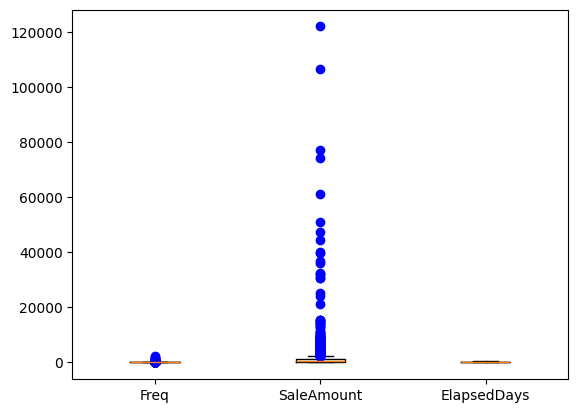

In [109]:
#현재 데이터 값의 분포 확인하기
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq'], customer_df['SaleAmount'], customer_df['ElapsedDays']], sym='bo')
plt.xticks([1, 2, 3], ['Freq', 'SaleAmount', 'ElapsedDays'])

plt.show()

In [111]:
#데이터 값의 왜곡(치우침)을 줄이기 위한 작업: 로그함수(log1p())로 분포조정
import numpy as np

customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])

customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346,1,77183.60,326,0.693147,11.253955,5.789960
1,12347,102,2205.95,184,4.634729,7.699367,5.220356
2,12348,28,1487.24,249,3.367296,7.305349,5.521461
3,12350,17,334.40,311,2.890372,5.815324,5.743003
4,12352,38,1561.81,263,3.663562,7.354241,5.575949


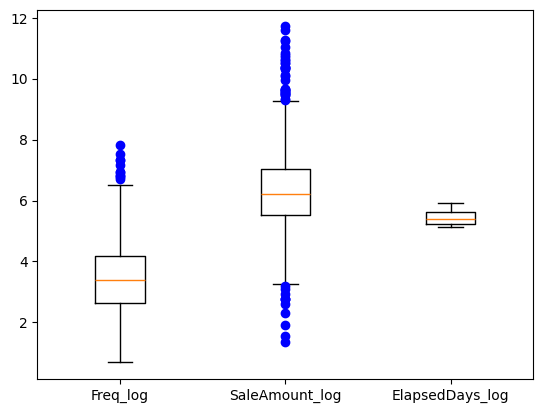

In [113]:
#조정된 데이터분포 다시 박스플롯으로 확인
fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq_log'], customer_df['SaleAmount_log'], customer_df['ElapsedDays_log']], sym='bo')
plt.xticks([1, 2, 3], ['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'])
plt.show()

In [114]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [116]:
#K-평균 모델에 사용할 값을 위해 Freq_log, SaleAmount_log, ElapseDays_log컬럼을 X_features에 저장
X_features = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values

In [117]:
#정규분포 다시 스케일링하기
#X_features를 정규 분포로 스케일링 StandardScaler().fit_transform하여 X_features_scaled에 저장
from sklearn.preprocessing import StandardScaler
X_features_scaled=StandardScaler().fit_transform(X_features)

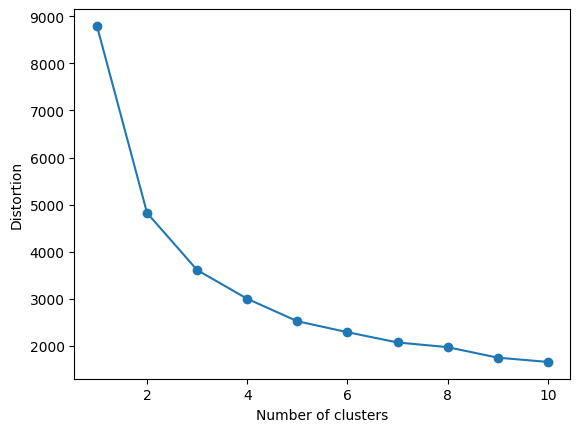

In [118]:
# 최적의 k 찾기 (1) 엘보우 방법 (최적의 K를 구하는 방법)
distortions = []

for i in range(1, 11):
    kmeans_i = KMeans(n_clusters=i, random_state=11)  # 모델 생성
    kmeans_i.fit(X_features_scaled)  # 모델 훈련
    distortions.append(kmeans_i.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()     #최적 k=3나옴

In [119]:
kmeans = KMeans(n_clusters=3, random_state=11)  # 모델 생성--cluster개수를 3으로함
# 모델 학습과 결과 예측(클러스터 레이블 생성)
Y_labels = kmeans.fit_predict(X_features_scaled)

In [120]:
customer_df['ClusterLabel'] = Y_labels

customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,2
1,12347,102,2205.95,184,4.634729,7.699367,5.220356,2
2,12348,28,1487.24,249,3.367296,7.305349,5.521461,2
3,12350,17,334.40,311,2.890372,5.815324,5.743003,1
4,12352,38,1561.81,263,3.663562,7.354241,5.575949,2


In [122]:
# 실루엣 분석 (군집 분석의 성능평가 방법)
# 최적의 K 찾기(2) 실루엣 계수에 따른 각 클러스터의 비중 시각화 함수 정의
from matplotlib import cm

def silhouetteViz(n_cluster, X_features):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes, height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)

    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title('Number of Cluster: ' + str(n_cluster) + '\n' + 'Silhouette Score: ' + str(round(silhouette_avg, 3)))

    plt.yticks(y_ticks, range(n_cluster))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()


In [123]:
# 클러스터 수에 따른 클러스터 데이터 분포의 시각화 함수 정의
def clusterScatter(n_cluster, X_features):
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster)  # 클러스터의 색상 설정
        c_colors.append(c_color)
        # 클러스터의 데이터 분포를 동그라미로 시각화
        plt.scatter(X_features[Y_labels == i, 0], X_features[Y_labels == i, 1],
                    marker='o', color=c_color, edgecolor='black', s=50,
                    label='cluster ' + str(i))

    # 각 클러스터의 중심점을 삼각형으로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1],
                    marker='^', color=c_colors[i], edgecolor='w', s=200)

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

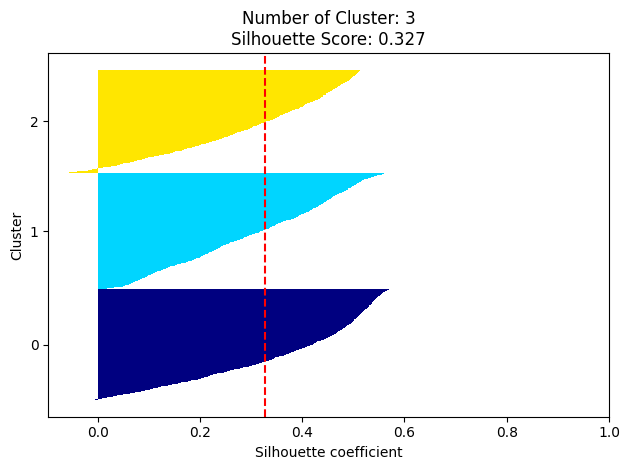

In [124]:
silhouetteViz(3, X_features_scaled)    #최적의 k 찾기 (1) 엘보우 방법에서 k=3나와서 cluster가 0,1,2임

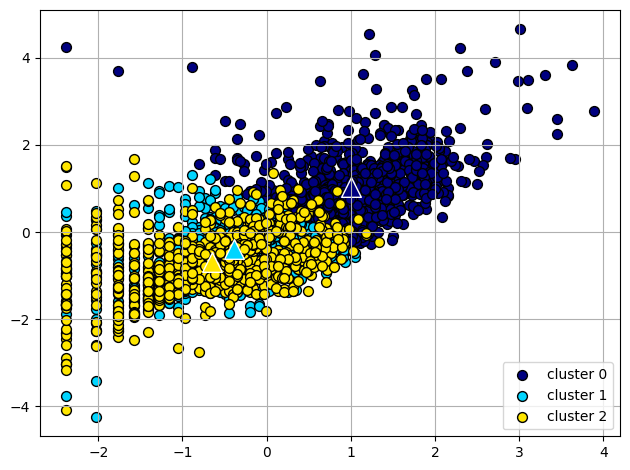

In [127]:
clusterScatter(3, X_features_scaled)  #클러스터간 겹침이 보임.다른 k값들과 비교해 가장 적절한 클러스터 개수 찾아야

In [128]:
#ClusterLabel이 추가된 데이터를 파일로 저장
customer_df.to_csv('Online_Retail_Customer_Cluster.csv')

In [129]:
#각 클러스터의 고객수
customer_df.groupby('ClusterLabel')['CustomerID'].count()

,CustomerID
ClusterLabel,
0,1026
1,920
2,985


In [134]:
print(customer_df.columns)

Index(['CustomerID', 'Freq', 'SaleAmount', 'ElapsedDays', 'Freq_log',
       'SaleAmount_log', 'ElapsedDays_log', 'ClusterLabel'],
      dtype='object')


In [136]:
#각 클러스터의 특징
customer_cluster_df=customer_df.drop(['Freq_log', 'SaleAmount_log','ElapsedDays_log'], axis=1,inplace=False)
customer_cluster_df

,CustomerID,Freq,SaleAmount,ElapsedDays,ClusterLabel
0,12346,1,77183.60,326,2
1,12347,102,2205.95,184,2
2,12348,28,1487.24,249,2
3,12350,17,334.40,311,1
4,12352,38,1561.81,263,2
...,...,...,...,...,...
2926,18273,1,51.00,258,1
2927,18280,10,180.60,278,1
2928,18281,7,80.82,181,0
2929,18283,322,812.04,170,2


In [137]:
#주문 1회당 평균 주문금액 : SaleAmountAvg
customer_cluster_df['SaleAmountAvg']=customer_cluster_df['SaleAmount']/customer_cluster_df['Freq']

In [138]:
#클러스터별 분석
customer_cluster_df.drop(['CustomerID'],axis=1,inplace=False).groupby('ClusterLabel').mean()

,Freq,SaleAmount,ElapsedDays,SaleAmountAvg
ClusterLabel,,,,
0,23.469786,426.895478,207.103314,34.454662
1,19.880435,335.592054,311.913043,41.080428
2,126.256853,3180.781331,202.601015,126.904456
